**Author**: Lawrence Stewart.

**Email**: lawrence.stewart@inria.fr

**Date**: 15/03/2023

In [1]:
import numpy as np
from tqdm import tqdm
from jax import grad, jit, vmap, value_and_grad
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import jaxopt
from jaxopt import perturbations # calling the version of jaxopt with variance reduction



For the case of $Z\sim N(0, I)$, the monte-carlo estimator for the randomized-smoothing gradient given in  [**Berthet et al. 2020**](https://proceedings.neurips.cc/paper/2020/file/6bb56208f672af0dd65451f869fedfd9-Paper.pdf) (Proposition 3.1):

\begin{equation} J_\theta y^*_\sigma(\epsilon) =  \mathbb{E}_Z[y^*(\theta + \sigma Z)\nabla_{\theta} \log P_Z(\theta) \frac{1}{\sigma}]\end{equation}

\begin{equation}
G_1 = J_\theta \hat{y}_\sigma^{(M)}(\theta) = \frac{1}{M}\sum_{j=1}^M y^*(\theta + \sigma Z)\nabla_{\theta}\log P_Z(\theta) \frac{1}{\sigma}
\end{equation}

explodes as $\sigma\rightarrow 0$. However, the modified estimator mentioned:

\begin{equation}
G_2 = J_\theta \hat{y}_\sigma^{(M)}(\theta) = \frac{1}{M}\sum_{j=1}^M (\,y^*(\theta + \sigma Z) - y^*(\theta)\,)\nabla_{\theta}\log P_Z(\theta) \frac{1}{\sigma},
\end{equation}

mentioned in [Le Lidec 2021](https://proceedings.neurips.cc/paper/2021/file/ab233b682ec355648e7891e66c54191b-Paper.pdf) and [Bach 2023](https://www.di.ens.fr/~fbach/ltfp_book.pdf) does not suffer this problem. Since $\mathbb{E}_Z[\nabla_{\theta}\log P_Z(\theta)] = 0$, $G_2$ is indeed an unbiased estimator of $ J_\theta y^*_\sigma(\epsilon)$.

Furthermore, if $f$ is $L$-smooth, and $Z\sim N(0,I)$ then [Bach 2023 Section 13.2.1](https://www.di.ens.fr/~fbach/ltfp_book.pdf) derives a bound on the variance of $G_2$ in , which notebly does not explode as $\sigma \rightarrow 0$. Hence, $G_2$ is preferable from a computational view-point over $G_1$ when the noise distribution is the standard Normal. 

This notebook showcases a small back-compatible modification made to `jaxopt.perturbations` in order to incorporate variance reduction (i.e. give the user the option to use $G_2$ over $G_1$). We demonstrate the effectiveness of the modification on a toy differentiable-ranking problem, similar to that of the [Jaxopt perturbation notebook](https://jaxopt.github.io/stable/notebooks/perturbed_optimizers/perturbed_optimizers.html).

In [2]:
# ranking and square loss function
def ranking(values):
    return jnp.argsort(jnp.argsort(values))

def square_loss(pred, target):
    return jnp.mean((pred - target) ** 2)


In [3]:
n = 25
# key for rng generation
rng = jrandom.PRNGKey(0)
np.random.seed(0)
# data to rank
X = jrandom.normal(rng, (n,))
# target label is to order the points
Y = jnp.arange(len(X))

Define forward and backward pass, as well as a training loop:

In [6]:
def make_perturbed_forward_backward(M=10, sigma=0.1, control_variate=False):

    # previous implementation
    ptb = perturbations.make_perturbed_argmax(
        ranking,
        num_samples=M,
        sigma=sigma,
        noise=perturbations.Normal(),
        control_variate=control_variate)
    @jit
    def forward(x, y, key):
        pred = ptb(x, key)
        return square_loss(pred, y)

    forward_backward = jit(value_and_grad(forward))
    return forward_backward


def train(M = 10, sigma=0.1, lr=1e-2, epochs=1000, control_variate=False):

    rng = jrandom.PRNGKey(0)
    losses = []
    grads = []

    fb = make_perturbed_forward_backward(M=M, sigma=sigma, control_variate=control_variate)

    Xt = jnp.copy(X)
    for t in range(epochs):
        rng, _ = jrandom.split(rng)
        l, g = fb(Xt, Y, rng)
        losses.append(l.item())
        grads.append(jnp.copy(g))
        Xt = Xt - lr * g

    return losses, grads

Train for $\sigma \in \{0.5, 0.1\}$ for varied values of $M \in \{1, 5, 50, 100, 1000\}$ with and without variance reduction:

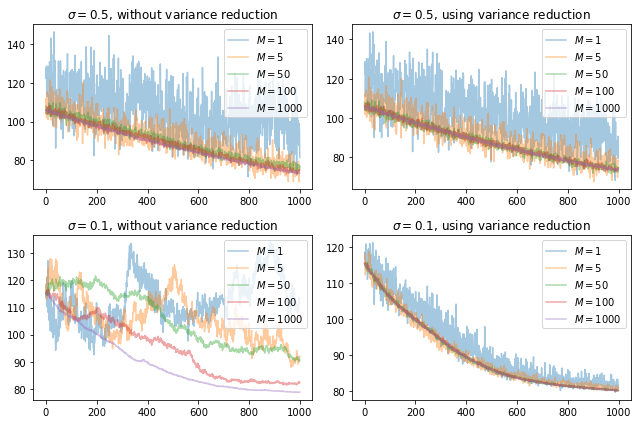

In [7]:
MVals = [1, 5, 50, 100, 1000]
MV = len(MVals)
EPOCHS = 1000
SigmaVals = [0.5, 0.1]
LR = 1e-4

fig, ax = plt.subplots(2, 2, figsize=(9, 6))
for i, sigma in enumerate(SigmaVals):
    for M in MVals:
        losses, _ = train(M=M, sigma=sigma, epochs=EPOCHS, lr=LR, control_variate=False)
        ax[i, 0].plot(losses, label=fr'$M = {M}$', alpha=0.4)
        losses, _ = train(M=M, sigma=sigma, epochs=EPOCHS, lr=LR, control_variate=True)
        ax[i, 1].plot(losses, label=fr'$M = {M}$', alpha=0.4)
        ax[i, 0].legend()
        ax[i, 1].legend()
        ax[i, 0].set_title(fr'$\sigma={sigma}$, without variance reduction')
        ax[i, 1].set_title(fr'$\sigma={sigma}$, using variance reduction')
fig.tight_layout()
plt.show()



We can see for the higher level of noise ($\sigma=0.5$) the two behaviour similarly (as expected). However, for a smaller level of noise ($\sigma=0.1$) there is increased variance in the gradients for the estimator $G_1$, which explodes as $\sigma \rightarrow 0$, whilst $G_2$ does not.

### References:


*Bach, F., 2021. Learning theory from first principles. Online version*.

*Berthet, Q., Blondel, M., Teboul, O., Cuturi, M., Vert, J.P. and Bach, F., 2020. Learning with differentiable pertubed optimizers. Advances in neural information processing systems, 33, pp.9508-9519*.

*Le Lidec, Q., Laptev, I., Schmid, C. and Carpentier, J., 2021. Differentiable rendering with perturbed optimizers. Advances in Neural Information Processing Systems, 34, pp.20398-20409*.

